<a href="https://colab.research.google.com/github/pranavkantgaur/gamd_sr/blob/main/sr_for_lj_potential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.10.0 on the current Colab Runtime...
2024-11-29 11:20:03 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.10/julia-1.10.0-linux-x86_64.tar.gz [168592090/168592090] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, broadwell)
  Threads: 3 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


In [2]:
using Pkg
Pkg.add("SymbolicRegression")
Pkg.add("MLJ")
Pkg.add("MLJBase")
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed DiffRules ──────────────── v1.15.1
   Installed IrrationalConstants ────── v0.2.2
   Installed DiffResults ────────────── v1.1.0
   Installed ScientificTypesBase ────── v3.0.0
   Installed Adapt ──────────────────── v4.1.1
   Installed ADTypes ────────────────── v1.11.0
   Installed StatisticalTraits ──────── v3.4.0
   Installed Tricks ─────────────────── v0.1.9
   Installed MLJModelInterface ──────── v1.11.0
   Installed PositiveFactorizations ─── v0.2.4
   Installed SpecialFunctions ───────── v2.4.0
   Installed Optim ──────────────────── v1.10.0
   Installed DataAPI ────────────────── v1.16.0
   Installed Setfield ───────────────── v1.1.1
   Installed ProgressMeter ──────────── v1.10.2
   Installed DynamicExpressions ─────── v1.5.0
   Installed StaticArraysCore ───────── v1.4.3
   Installed OrderedCollections ─────── v1.7.0
   Installed NaNMath ────────────────── v1.0.2
   Insta

In [50]:
using SymbolicRegression
function lj_potential_structure((; attr_func, rep_func), (rad, ))
  _attr_func = attr_func(rad)^-10
  _rep_func = rep_func(rad)^-6

  out = map((attr_func_i, rep_func_i) -> (attr_func_i - rep_func_i), _attr_func.x, _rep_func.x)
  return ValidVector(out, _attr_func.valid && _rep_func.valid)
end
lj_structure = TemplateStructure{(:attr_func, :rep_func)}(lj_potential_structure)

(::TemplateStructure{(:attr_func, :rep_func), typeof(lj_potential_structure), @NamedTuple{attr_func::Int64, rep_func::Int64}}) (generic function with 0 methods)

Min value: 0.1


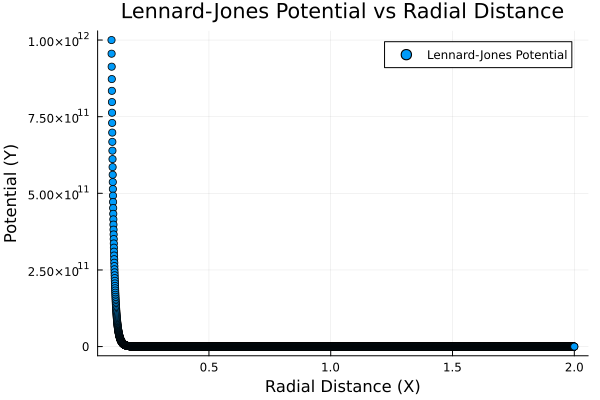

In [30]:
using LinearAlgebra
using Plots

# Set parameters for Lennard-Jones potential
epsilon = 1.0  # Depth of the potential well
sigma = 1.0    # Finite distance at which the potential is zero

# Generate random radial distances
X = Vector(range(0.1, stop=2.0, length=5000))  # Avoid zero to prevent division by zero

# Reshape X into a column vector
X = reshape(X, :, 1)

# Find the smallest value
min_value = minimum(X)
println("Min value: ", min_value)



# Calculate Lennard-Jones potential for each radial distance
Y = [
     ((sigma / norm(X[i, :]))^12 - (sigma / norm(X[i, :]))^6)
     #(-(sigma / norm(X[i, :]))^6)
     #((sigma / norm(X[i, :]))^12)
    for i in eachindex(axes(X, 1))
]

# Y now contains the Lennard-Jones potentials corresponding to each radial distance


# Plotting Y as a function of X
plot(X, Y, seriestype = :scatter, label = "Lennard-Jones Potential", xlabel = "Radial Distance (X)", ylabel = "Potential (Y)", title = "Lennard-Jones Potential vs Radial Distance", legend = true)

In [14]:
elementwise_loss = ((x1), (y1)) -> abs(y1 - x1)

#9 (generic function with 1 method)

In [51]:
using MLJBase

model = SRRegressor(;
    niterations=100,
    selection_method=SymbolicRegression.MLJInterfaceModule.choose_best,
    binary_operators=(*, /),
    maxsize=15,
    elementwise_loss=elementwise_loss,
    expression_type=TemplateExpression,
    # Note - this is where we pass custom options to the expression type:
    expression_options=(; structure = lj_structure),
    batching=true,
)


mach = machine(model, X, Y)
fit!(mach)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
Evolving for 100 iterations... 100%|█████████████████████████████████████████| Time: 0:02:27


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
2           4.825e+09  1.802e+01  ╭ attr_func = #1
                                  ╰ rep_func = 1.7555
4           6.973e+08  9.672e-01  ╭ attr_func = #1 * -0.64072
                                  ╰ rep_func = #1
6           3.484e+08  3.469e-01  ╭ attr_func = #1 * -0.62197
                                  ╰ rep_func = #1 * -0.13048
8           3.484e+08  2.243e-05  ╭ attr_func = #1 * -0.62197
                                  ╰ rep_func = -1.001 * (-0.13048 * #1)
───────────────────────────────────────────────────────────────────────────────────────────────────
  - outputs/20241129_123419_9lukGX/hall_of_fame.csv


[ Info: Final population:
[ Info: Results saved to:


trained Machine; caches model-specific representations of data
  model: SRRegressor(defaults = nothing, …)
  args: 
    1:	Source @405 ⏎ AbstractMatrix{Continuous}
    2:	Source @942 ⏎ AbstractVector{Continuous}


In [52]:
report(mach)

(best_idx = 3,
 equations = TemplateExpression{Float64, TemplateStructure{(:attr_func, :rep_func), typeof(lj_potential_structure), @NamedTuple{attr_func::Int64, rep_func::Int64}}, DynamicExpressions.NodeModule.Node{Float64}, ComposableExpression{Float64, DynamicExpressions.NodeModule.Node{Float64}, @NamedTuple{operators::DynamicExpressions.OperatorEnumModule.OperatorEnum{Tuple{typeof(*), typeof(/)}, Tuple{}}, variable_names::Nothing}}, @NamedTuple{attr_func::ComposableExpression{Float64, DynamicExpressions.NodeModule.Node{Float64}, @NamedTuple{operators::DynamicExpressions.OperatorEnumModule.OperatorEnum{Tuple{typeof(*), typeof(/)}, Tuple{}}, variable_names::Nothing}}, rep_func::ComposableExpression{Float64, DynamicExpressions.NodeModule.Node{Float64}, @NamedTuple{operators::DynamicExpressions.OperatorEnumModule.OperatorEnum{Tuple{typeof(*), typeof(/)}, Tuple{}}, variable_names::Nothing}}}, @NamedTuple{structure::TemplateStructure{(:attr_func, :rep_func), typeof(lj_potential_structure)

In [53]:
r = report(mach)
idx = r.best_idx
best_expr = r.equations[idx]
best_attr = get_contents(best_expr).attr_func
best_rep = get_contents(best_expr).rep_func

print("Attr term: ", best_attr)
print("\nRep term: ", best_rep)


Attr term: x1 * -0.6219708625490797
Rep term: x1 * -0.13048213652046795

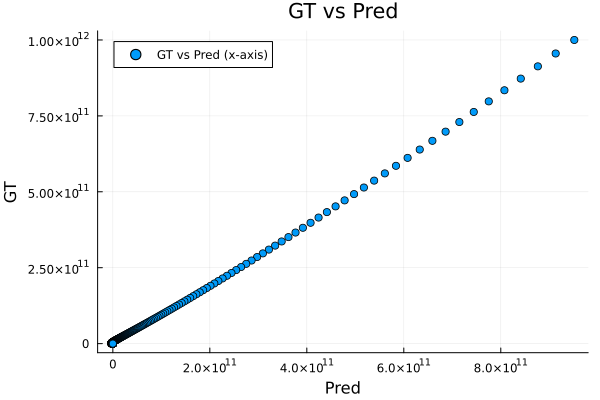

In [54]:
y_pred = predict(mach, X)
# Plotting Y as a function of X
plot(y_pred, Y, seriestype = :scatter, label = "GT vs Pred (x-axis)", xlabel = "Pred", ylabel = "GT", title = "GT vs Pred", legend = true)